In [1]:
from main import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import argparse
#from collections import namedtuple

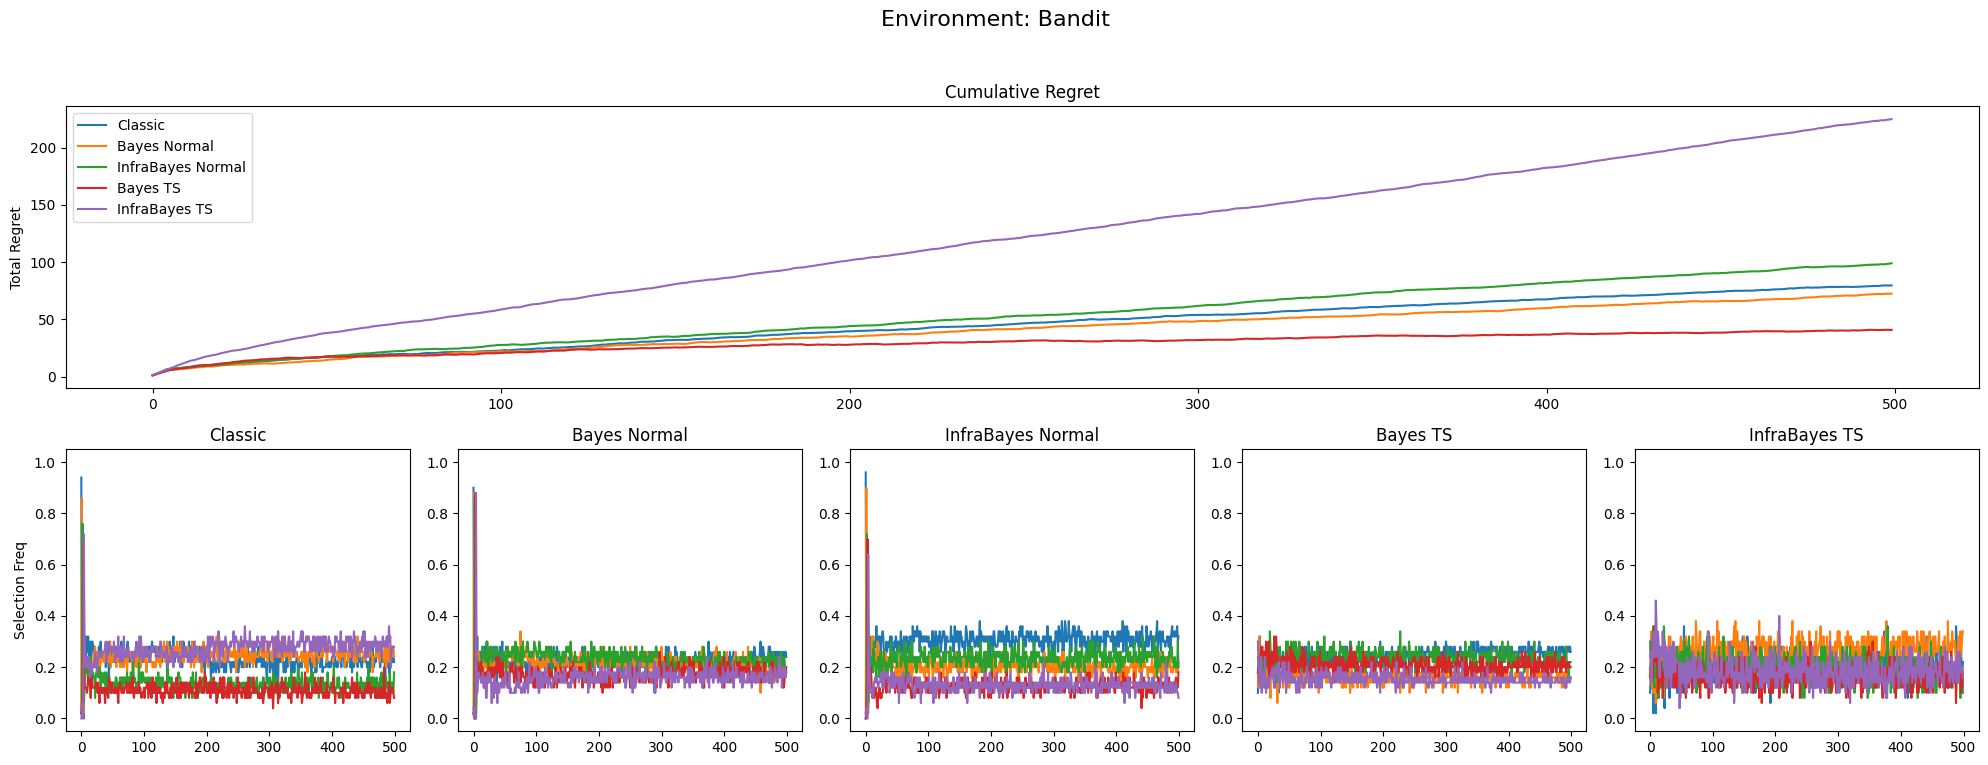

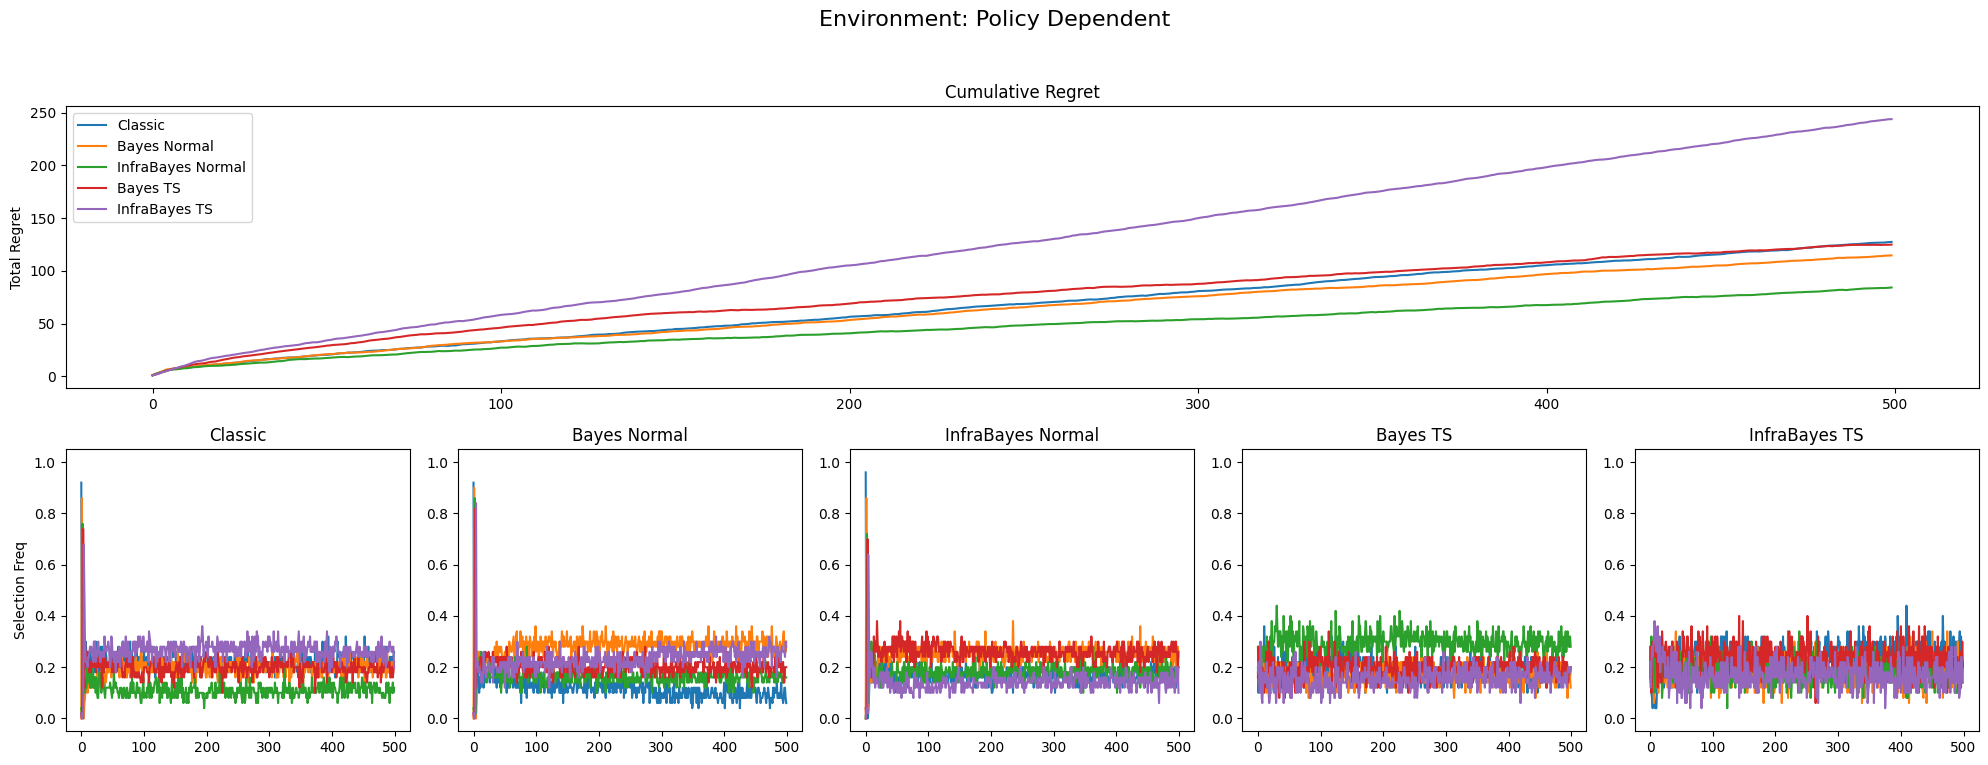

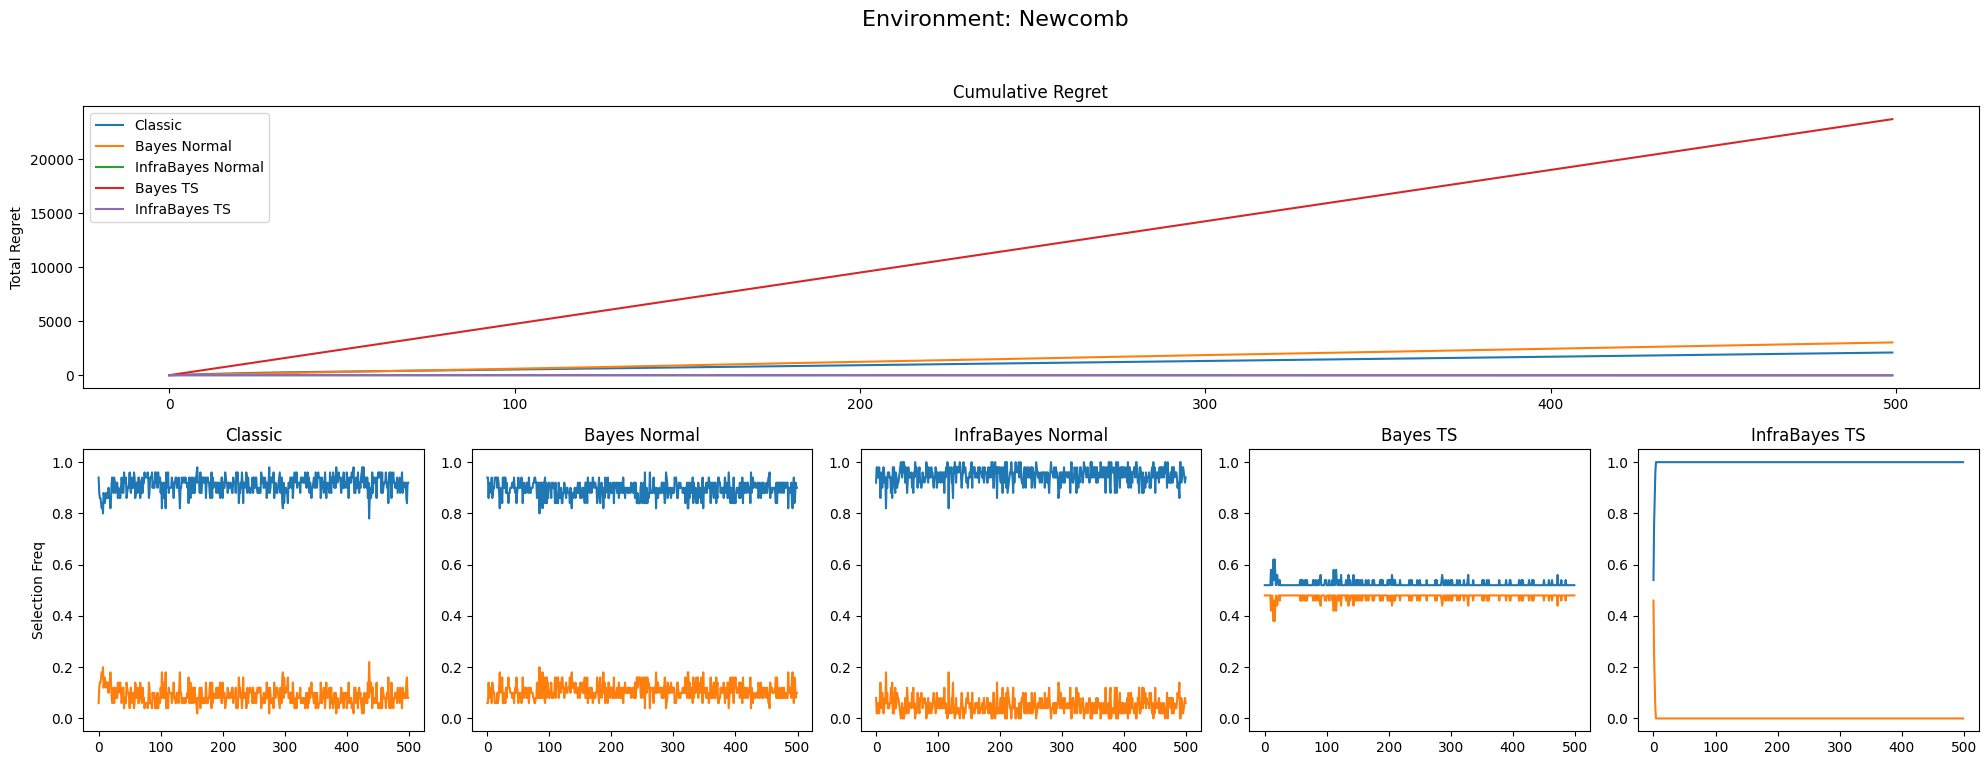

In [3]:
def simulate(env_cls, agent_cls_list, k_arms, steps=500, runs=50):
    results = {}
    for name, cls in agent_cls_list:
        regrets = np.zeros((runs, steps))
        actions = np.zeros((runs, steps))
        
        for r in range(runs):
            env = env_cls(k=k_arms) # Pass k_arms here
            agent = cls(k=env.num_arms)
            opt_r = env.get_best_reward()
            
            for s in range(steps):
                greedy_pred = agent.get_greedy_action()
                act = agent.get_action()
                
                # Handle environments that might not take 'prediction'
                if isinstance(env, (PolicyDependentBanditEnvironment, NewcombEnvironment)):
                    rew = env.interact(act, greedy_pred)
                else:
                    rew = env.interact(act)
                
                agent.update(act, rew, greedy_pred)
                regrets[r, s] = opt_r - rew
                actions[r, s] = act
        results[name] = (np.cumsum(regrets, axis=1).mean(axis=0), actions)
    return results

# ---------------------------------------------------------
# 4. Running and Plotting
# ---------------------------------------------------------

agents_list = [
    ("Classic", ClassicalAgent),
    ("Bayes Normal", BayesianAgent),
    ("InfraBayes Normal", InfrabayesianAgent),
    ("Bayes TS", BayesianThompsonAgent),
    ("InfraBayes TS", InfrabayesianThompsonAgent)
]

envs_list = [
    ("Bandit", BanditEnvironment, 5), 
    ("Policy Dependent", PolicyDependentBanditEnvironment, 5), 
    ("Newcomb", NewcombEnvironment, 2)
]

for env_name, env_cls, k_val in envs_list:
    sim_results = simulate(env_cls, agents_list, k_val)
    
    fig = plt.figure(figsize=(20, 8))
    fig.suptitle(f"Environment: {env_name}", fontsize=16)
    
    ax_regret = plt.subplot2grid((2, 5), (0, 0), colspan=5)
    for name, (regret, _) in sim_results.items():
        ax_regret.plot(regret, label=name)
    ax_regret.set_title("Cumulative Regret")
    ax_regret.set_ylabel("Total Regret")
    ax_regret.legend()

    for i, (name, (regret, actions)) in enumerate(sim_results.items()):
        ax_act = plt.subplot2grid((2, 5), (1, i))
        for arm in range(k_val):
            freq = (actions == arm).mean(axis=0)
            ax_act.plot(freq, label=f"Arm {arm}")
        ax_act.set_title(f"{name}")
        ax_act.set_ylim(-0.05, 1.05)
        if i == 0: ax_act.set_ylabel("Selection Freq")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()